# Corporate predictions

Brief explanation about following
will be showed approach used to predict corporate european financial sector companies Ratio Table indices for 2023, 2024, 2025 using data of 2019, 2020, 2021, 2022. About the entire datasets it has small size (1046 rows) and 9 incides that will be predicted (as *Return on Equity*, *Operating Margin*, etc.).

**Steps followed**:
* Standardization process
* Optuna framework to find best params
* Use best params to create model (adjusted in some params)
* Make predictions for 2023, 2023,2025

**Decision on using deep learning model LSTM (Long Short Time Memory)**: behind the reason there is the dataset structure, which is small and needs to remember information passed, considering multivariate approach and also time-series reference.

**Important:**
* this notebook just want to show a  process used by myself, so it's no for any suggesting.
* some code  has been removed, just to focus main part of this notebook

### <u>Set Up

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [ ]:
pd.set_option('display.max_rows', None) # remove None if you prefer not defoult entire table to print
pd.set_option('display.max_columns', None)

### <u>Original dataset used

In [50]:
rt_comp.sort_values(by=['Company Name','Year']).head(10)

,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA,year
Company Name,,,,,,,,,,
ABC Arbitrage S.A.,2019-12-31,0.044072,0.347287,0.016011,0.001907,0.131094,0.485101,0.299175,0.093327,2019
ABC Arbitrage S.A.,2020-12-31,0.109962,0.060431,0.007466,0.000761,0.227813,0.513240,0.236496,0.050589,2020
ABC Arbitrage S.A.,2021-12-31,0.443052,0.214059,0.033683,0.000509,0.175228,0.549736,0.233405,0.063542,2021
ABC Arbitrage S.A.,2022-12-31,0.137031,0.222049,0.035259,0.002229,0.180317,0.474609,0.217092,0.061172,2022
ABG Sundal Collier Holding ASA,2019-12-31,0.669604,0.043507,0.087789,0.099882,0.329103,0.251407,0.078344,0.176473,2019
ABG Sundal Collier Holding ASA,2020-12-31,0.717579,0.103739,0.262553,0.065154,0.460623,0.329150,0.065579,0.235465,2020
ABG Sundal Collier Holding ASA,2021-12-31,0.702179,0.175579,0.413967,0.038596,0.628008,0.357388,0.031106,0.143102,2021
ABG Sundal Collier Holding ASA,2022-12-31,0.737245,0.197644,0.554553,0.178240,0.264961,0.233129,0.053442,-0.028984,2022
AIA Group Ltd.,2019-12-31,0.802752,0.036240,0.146931,0.034769,0.109427,0.199619,0.033673,-0.049144,2019


### <u>Indices (columns) to predict

In [1265]:
cols = ['Liabilities to Assets', 'Debt to Liabilities', 
        'Debt to Equity', 'InterestExp to EBIT', 'Return On Equity', 'Total_Shareholders_Equity', # check with and not this last one
       'Operating Margin', 'Capex to EBIT', 'D&A aprox to EBITDA']

### <u>UDF plotting

In [991]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Track history model graph

    Param: history (variable reference)
    """
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Could not be val loss
    epochs_range = range(1, len(train_loss) + 1)  # Epoch start from 1
    
    plt.figure(figsize=(12, 6))
    
    # --- Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    # --- Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

# Main goal of predictions
Predict future years 2023, 2024, 2025 for whole sector (considering all variables inside 'cols')

**NOTE:** model has not seed setted, because main is find model wich it's as stable as possibile in its predictions tests.
However, you can set seed if consider model is fitted for you requirement.

### Preprocessing data

In [1370]:
from sklearn.preprocessing import MinMaxScaler

rt_comp = rt_comp.reset_index()
df_sorted = rt_comp.sort_values(by=['year', 'Company Name'])
df_values = df_sorted[cols]
data_matrix = df_values.values.reshape(len(rt_comp['year'].unique()), -1)
scaler = MinMaxScaler(feature_range=(0, 1)) # best fitted considering error and predictions
scaled_data = scaler.fit_transform(data_matrix)

In [1371]:
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x, seq_y = data[i:i+n_steps], data[i+n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [1372]:
train = scaled_data[:]
valid = scaled_data[2:]
X_train, y_train = prepare_data(train, 1)
X_valid, y_valid = prepare_data(valid, 1)

In [1373]:
X_train.shape

(3, 1, 2070)

In [1374]:
X_valid.shape

(1, 1, 2070)

In [1375]:
scaled_data.shape

(4, 2070)

### <u>  LSTM + Optuna (hyperparameter tuning)

In [1219]:
import optuna
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

***Get best params***

In [1002]:
def objective(trial, X_train, y_train, X_valid, y_valid, n_steps=None, 
                                  n_input_units=None, epochs=None, weight_initializer=None): # seed=None
    
    # Hyper. optimization range
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units_2 = trial.suggest_int('n_units_2', 100, 200) # try to capture complex scheme of model 
    n_units = trial.suggest_int('n_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    activation_function = trial.suggest_categorical('activation_function', ['tanh', 'LeakyReLU', 'PReLU', 'softplus', 'elu']) # mish
    
    # Default inizializer 'GlorotUniform'
    if weight_initializer == 'GlorotNormal':
        initializer = GlorotNormal(seed=trial.number)
    elif weight_initializer == 'HeNormal':
        initializer = HeNormal(seed=trial.number)
    else:
        initializer = GlorotUniform(seed=trial.number) # Default initializer

    model = Sequential()

    # Input Layer
    # n_units_2 - it will help to capture complex scheme (but also could straight to overfitting)
    model.add(LSTM(n_units_2, activation=activation_function, return_sequences=True, input_shape=(n_steps, n_input_units), kernel_initializer=initializer))
    model.add(Dropout(dropout_rate)) # it help to prevent overfitting

    # Hidden Layers
    for _ in range(n_layers - 1):  # Add n_layers - 1 layer LSTM
        model.add(LSTM(n_units, activation=activation_function, return_sequences=True, kernel_initializer=initializer))
        model.add(Dropout(dropout_rate))

    # Last Layer LSTM
    model.add(LSTM(n_units, activation=activation_function, kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(n_input_units))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # track and stop is validation not improve
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001) # reduce learning rate once metric does not increse

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), callbacks=[early_stop, reduce_lr])

    # Get the minimum validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss

In [51]:
tf.keras.backend.clear_session() # cleaning by previous section (remove potential residual left)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid, 1, X_train.shape[2], 200, weight_initializer=None), n_trials=150) # seed=trial.number

### Best params found

In [1077]:
def print_study_results(studies):
    """
    Pass Optuna study
    """
    for idx, study in enumerate(studies, 1):
        print(f"--- Study {idx} ---")
        print('Number of finished trials: ', len(study.trials), '(it is also seed number)')
        print('Best trial:')
        trial = study.best_trial
        print('Value: ', trial.value)
        print('Params: ', trial.params)
        print('Seed: ', trial.number)
        print('---' * 10)  # to separate studies with lines

In [1078]:
studies = [study]
print_study_results(studies)

--- Study 1 ---
Number of finished trials:  28 (it is also seed number)
Best trial:
Value:  0.002496926346793771
Params:  {'n_layers': 2, 'n_units': 117, 'dropout_rate': 0.420725059803861, 'learning_rate': 0.0009978640431815297, 'batch_size': 32, 'activation_function': 'tanh'}
Seed:  24
------------------------------


### Manual pass best parameters found by optuna
Reason that params has not been pass directly, is because in this way if you find something to change in order to improve model
you can directly manage easier

In [1376]:
from tensorflow.keras.layers import BatchNormalization, GRU, LSTM, SimpleRNN
from tensorflow.keras.initializers import GlorotNormal, HeNormal, GlorotUniform

def create_and_train_model_manual(algo=None, X_train=None, y_train=None, X_valid=None, y_valid=None, 
                                  n_steps=None, n_layers=None, n_units_2=None,
                                  n_units=None, dropout_rate=None, 
                                  learning_rate=None, batch_size=None, n_input_units=None, 
                                  epochs=None, activation_function=None,
                                  weight_initializer='GlorotUniform', seed=None):
    
    print('Model used', algo)
    
    if weight_initializer == 'GlorotNormal':
        initializer = GlorotNormal()
    elif weight_initializer == 'HeNormal':
        initializer = HeNormal()
    else:
        initializer = GlorotUniform()

    model = Sequential()

    # Input Layer
    model.add(algo(n_units_2, return_sequences=True, activation=activation_function, input_shape=(n_steps, n_input_units), kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    for _ in range(n_layers - 1):
        model.add(algo(n_units, activation=activation_function, return_sequences=True, kernel_initializer=initializer))
        model.add(Dropout(dropout_rate))

    # Second layer
    model.add(algo(n_units, activation=activation_function, kernel_initializer=initializer))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(n_input_units))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # it will help to sto p process id does not improve
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_valid, y_valid), callbacks=[early_stop, reduce_lr], verbose=1)
    
    plot_training_history(history)
    
    return model, history

In [ ]:
# Process will be passed
best_params = {'n_layers': 2, 'n_units': 117, 'dropout_rate': 0.420725059803861, 'learning_rate': 0.0009978640431815297, 'batch_size': 32, 'activation_function': 'tanh'}

Model used <class 'keras.src.layers.rnn.lstm.LSTM'>


C:\Users\utente\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/200
1/1 [==============================] - 12s 12s/step - loss: 0.3575 - val_loss: 0.3652 - lr: 9.9786e-04
Epoch 2/200
1/1 [==============================] - 0s 138ms/step - loss: 0.3557 - val_loss: 0.3625 - lr: 9.9786e-04
Epoch 3/200
1/1 [==============================] - 0s 156ms/step - loss: 0.3525 - val_loss: 0.3579 - lr: 9.9786e-04
Epoch 4/200
1/1 [==============================] - 0s 144ms/step - loss: 0.3486 - val_loss: 0.3517 - lr: 9.9786e-04
Epoch 5/200
1/1 [==============================] - 0s 141ms/step - loss: 0.3452 - val_loss: 0.3438 - lr: 9.9786e-04
Epoch 6/200
1/1 [==============================] - 0s 132ms/step - loss: 0.3371 - val_loss: 0.3344 - lr: 9.9786e-04
Epoch 7/200
1/1 [==============================] - 0s 140ms/step - loss: 0.3245 - val_loss: 0.3232 - lr: 9.9786e-04
Epoch 8/200
1/1 [==============================] - 0s 134ms/step - loss: 0.3203 - val_loss: 0.3107 - lr: 9.9786e-04
Epoch 9/200
1/1 [==============================] - 0s 154ms/step - loss: 

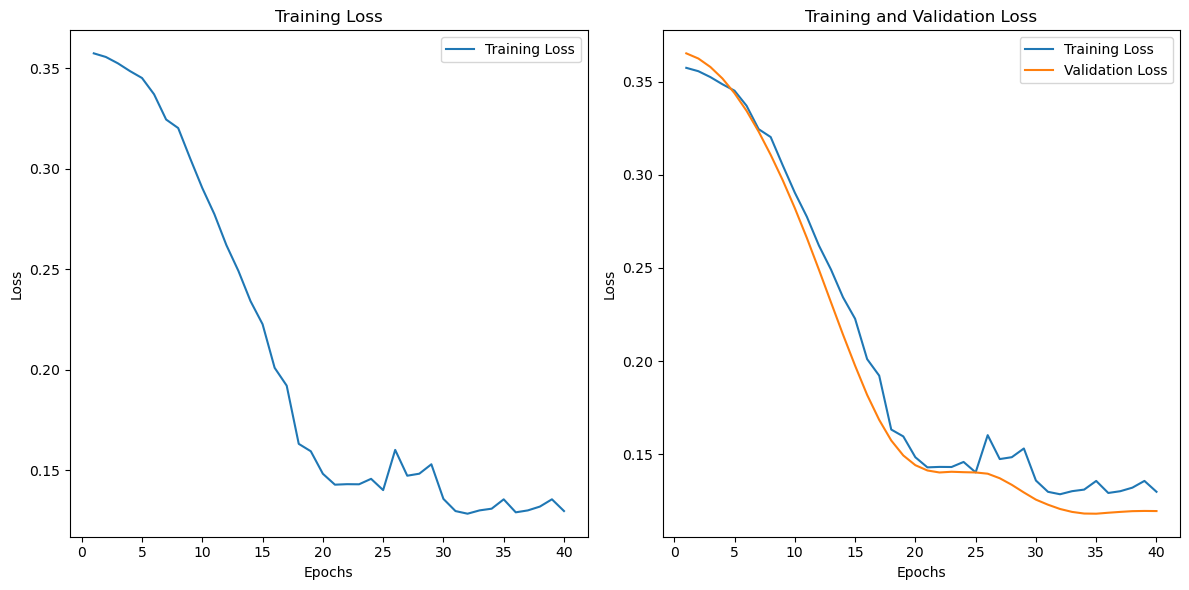

In [1403]:
# Set result got
tf.keras.backend.clear_session()

model, history = create_and_train_model_manual(algo=LSTM,
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                X_valid=X_valid, 
                                                y_valid=y_valid,
                                                n_steps=1, # time period past considering
                                                n_layers= 1, # best_params['n_layers'],
                                                n_units_2= 150, # this param is added manually
                                                n_units=best_params['n_units'],
                                                dropout_rate=best_params['dropout_rate'], 
                                                learning_rate= best_params['learning_rate'],
                                                batch_size=best_params['batch_size'],
                                                n_input_units=X_train.shape[2],
                                                epochs=200, # this param is added manually
                                                activation_function=best_params['activation_function']
                                                weight_initializer='GlorotUniform',
                                                seed=np.random
                                            ) 

### Validation

In [1404]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Valutation loss')
test_loss = model.evaluate(X_valid, y_valid)
print(f'Test Loss: {test_loss}')

print('\nError')
# Predict
predictions = model.predict(X_valid)

# Invert the scaling for predictions
inv_predictions = scaler.inverse_transform(predictions)

# Invert the scaling for actual values
inv_y_valid = scaler.inverse_transform(y_valid)

# Calculate metrics
mse = mean_squared_error(inv_y_valid, inv_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_y_valid, inv_predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Valutation loss
1/1 [==============================] - 0s 56ms/step - loss: 0.1180
Test Loss: 0.11802812665700912

Error
1/1 [==============================] - 2s 2s/step
Mean Squared Error (MSE): 0.1579446793267973
Root Mean Squared Error (RMSE): 0.3974225450660761
Mean Absolute Error (MAE): 0.14321656824603857


### Settings and predict next periods: 2023, 2024, 2025

In [1406]:
comp = sorted(comp_names)
variables = cols 

# Reshaping the data
reshaped_actual = inv_y_valid.reshape(len(comp), len(variables))
reshaped_predictions = inv_predictions.reshape(len(comp), len(variables))

# Convert to DataFrame
actual_df = pd.DataFrame(reshaped_actual, columns=variables, index=comp)
predicted_df = pd.DataFrame(reshaped_predictions, columns=variables, index=comp)

comparison_df = pd.concat([actual_df, predicted_df], axis=1, keys=['Actual', 'Predicted'])

In [1407]:
# Just show difference beetwen actual and predicted (considering test)
difference_df = actual_df - predicted_df
# difference_df # difference beetwen predicted and real one

**Predict for 2023, 2024 and 2025**

In [1408]:
n_steps = 1
n_future = 3
input_units = X_valid.shape[2]
future_predictions = predict_future(model_lstm, scaled_data, n_steps, input_units, n_future)

1/1 [==============================] - 0s 57ms/step


**Organized and set dataset to 2023, 2024, 2025 predictions data**

In [1411]:
predictors = cols
pred_df = create_prediction_dataframe(unscaled_predictions, comp, predictors)

### Predicted dataset

In [1465]:
pred_df

,company,year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
0,ABC Arbitrage S.A.,2023,0.203714,0.216427,0.033325,0.001909,0.180278,0.489236,0.221343,0.059939
1,ABC Arbitrage S.A.,2024,0.186909,0.219568,0.034725,0.002018,0.177794,0.484363,0.219677,0.060185
2,ABC Arbitrage S.A.,2025,0.185475,0.219709,0.034822,0.002027,0.177685,0.483941,0.219557,0.060170
3,ABG Sundal Collier Holding ASA,2023,0.729091,0.193191,0.535703,0.141380,0.365124,0.261909,0.052360,0.003640
4,ABG Sundal Collier Holding ASA,2024,0.730825,0.197609,0.548959,0.153102,0.335794,0.252199,0.052953,-0.018774
5,ABG Sundal Collier Holding ASA,2025,0.731019,0.197921,0.550036,0.153964,0.333346,0.251419,0.053059,-0.020396
6,AIA Group Ltd.,2023,0.854835,0.049855,0.317646,0.175509,0.038448,0.087751,0.255159,-0.203139
7,AIA Group Ltd.,2024,0.859277,0.050722,0.331047,0.189797,0.028972,0.073823,0.276550,-0.231231
8,AIA Group Ltd.,2025,0.859651,0.050792,0.332160,0.190970,0.028149,0.072762,0.278158,-0.233544
9,AIB Group PLC,2023,0.908754,0.112884,1.114891,0.354212,0.058755,0.259619,0.247203,0.184503
